# Practical 1 $\delta^{18}O$ worksheet
Make sure you've opened this notebook in Binder - that way, all the python dependencies should be okay!



In [6]:
## import modules - don't change this! 
import numpy as np # numpy is the cornerstone of coding in python
import pandas as pd # pandas to work with tables (think excel on steroids)
import xarray as xr # xarray to work with n-dimensional datasets
import cartopy.crs as ccrs # cartopy for map projections
import matplotlib.pyplot as plt # import pyplot from matplotlib for plotting tools

## Load datasets
We need data for:
- temperature
- d18O of seawater

We want this data to be gridded (with lat, lon, and depth dimensions), and available as monthly climatologies (i.e. average values for Jan, Feb... etc.)

We're going to use data from [this study by Charlotte Breitkreuz et al., in 2018](https://doi.org/10.1029/2018JC014300). I accessed the original data [here](https://doi.pangaea.de/10.1594/PANGAEA.889922) and cleaned it up a little to make life easier. You can see exactly what I did in the `data/clean_data.py` file on the github page for this session. The full data reference is:
>Supplement to: Breitkreuz, C et al. (2018): A dynamical reconstruction of the global monthly-mean oxygen isotopic composition of seawater. Journal of Geophysical Research: Oceans, 123(10), 7206-7219, https://doi.org/10.1029/2018JC014300 

In [7]:
# load gridded ocean data (including d18Osw, temperature, and salinity on a 1x1 latxlon grid)
ocean_data = xr.open_dataset('data/gridded_seawater_data.nc') # load the netcdf file into an xarray dataset
ocean_data # running this cell should output the dataset info, you can click on the variables to get metadata etc.

<xarray.Dataset> Size: 3MB
Dimensions:  (month: 12, depth: 6, lat: 46, lon: 51)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * depth    (depth) float64 48B 25.0 85.0 170.0 290.0 455.0 670.0
  * lat      (lat) float64 368B -35.0 -32.5 -30.0 -27.5 ... 70.0 72.5 75.0 77.5
  * lon      (lon) float64 408B -90.0 -87.5 -85.0 -82.5 ... 27.5 30.0 32.5 35.0
Data variables:
    d18Osw   (month, depth, lat, lon) float64 1MB ...
    T        (month, depth, lat, lon) float64 1MB ...
Attributes:
    description:    gridded climatology from Breitkruez et al., 2018 (https:/...
    regrid_method:  bilinear

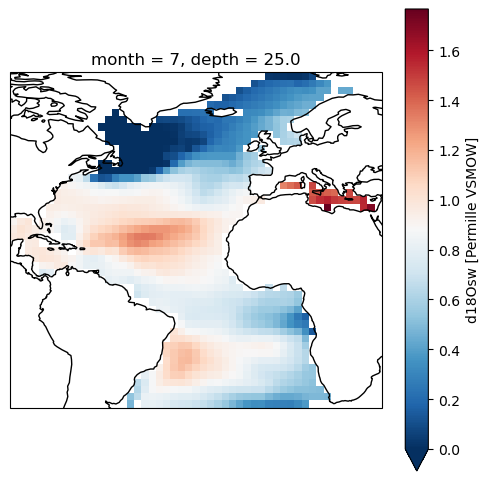

In [8]:
## first look at the data
# use the .sel syntax to select data from the month of July and the 25m depth level
f = plt.figure(figsize=(6,6)) # initialise an empty figure
ax = f.add_subplot(111,projection=ccrs.PlateCarree())
ocean_data.sel(depth=25,month=7)['d18Osw'].plot(
    vmin=0, # set the minimum color as 0
    cmap='RdBu_r', # use a red and blue colormap
    ax=ax, # use the axis we made above
    transform=ccrs.PlateCarree() # set the map projection to use
)
ax.coastlines() # add coastlines for reference


## Task 1
Now do the same but for temperature instead of d18Osw:

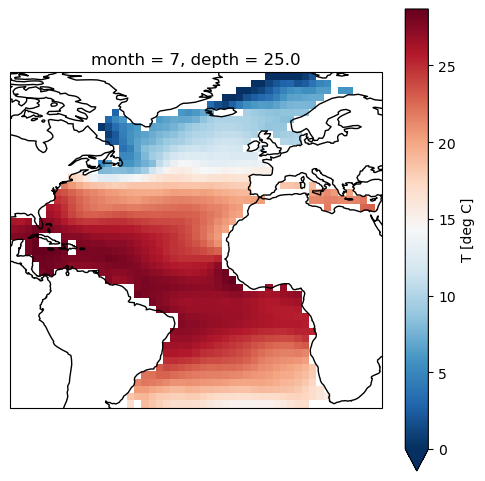

In [5]:
## your code here!
f = plt.figure(figsize=(6,6)) # initialise an empty figure
ax = f.add_subplot(111,projection=ccrs.PlateCarree())
ocean_data.sel(depth=25,month=7)['T'].plot(
    vmin=0, # set the minimum color as 0
    cmap='RdBu_r', # use a red and blue colormap
    ax=ax, # use the axis we made above
    transform=ccrs.PlateCarree() # set the map projection to use
)
ax.coastlines() # add coastlines for reference